In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib as mpl
from textwrap import wrap
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.sans-serif"] = "Times New Roman"
mpl.rcParams["font.size"] = 14
viridis_colors=['#440154', '#414487', '#2a788e', '#22a884', '#7ad151', '#fde725']

In [2]:
factor_explored = 'InspectionDuration'

In [3]:
def read_and_merged(merged_df, base_path, file_name, xlsx_name, columns_of_interest, aggregate_with = "mean"):
    file_path = base_path + file_name + '/' + xlsx_name + '.xlsx'
    datafile =  pd.read_excel(file_path)
    if aggregate_with=="mean":
        datafile = datafile.groupby("Replication Id")[columns_of_interest].mean().reset_index()
    elif aggregate_with=="sum":
        datafile = datafile.groupby("Replication Id")[columns_of_interest].sum().reset_index()
    merged_df = pd.merge(merged_df, datafile, on=['Replication Id'], how='right')
    return merged_df

In [4]:
merged_dfs = []
run_length = 28 #days
no_chambers = 3
periodic_duration = 2 #hours

regime = '40_80_10'
fleet_mix = 'AlternativeFleetMix'
base_path = "data/Experiments/UnivariateAnalysis/" + factor_explored


input_file_path = base_path + '/Scenario Parameters.xlsx'
input_df =  pd.read_excel(input_file_path, index_col=0)
no_set_per_file = len(input_df)
input_df['FleetMix'] = fleet_mix
input_df['LockingRegime'] = regime

kpi_file_path = base_path + '/KPI Locks Summary.xlsx'
kpi_df =  pd.read_excel(kpi_file_path, index_col=0)
kpi_df['SetNo'] = 1 + (kpi_df.index -1) % no_set_per_file

# Adding Emission calculation to kpi_df
file_path = base_path + '/KPI Emissions Locks.xlsx'
datafile =  pd.read_excel(file_path)
datafile = datafile[datafile["Emission substance"]== "CO2"].loc[:,["Replication Id", "Emissions slowsteaming (kg/day)"]]
kpi_df = pd.merge(kpi_df, datafile, on=['Replication Id'], how='right')

# Merging these two dataframes
merged_df = pd.merge(input_df, kpi_df, on=['SetNo'], how='right')

merged_dfs.append(merged_df)

experiments = pd.concat(merged_dfs)
# del(merged_dfs)
experiments.describe()

,SetNo,TrafficRange,FleetIntensity,FlutteringProbability,MTTR,SlowDownEffect,MeanSlowDownCounter,PeriodicInspection,InspectionStart,InspectionDuration,...,Avg Occupancy (%),Max number of ships waiting,Avg passage time (minutes),Avg waiting time (minutes),Service Level (%),Total Waiting Time (hours),Total Leveling Time (hours),Avg ships per leveling,Avg ships per filled leveling,Emissions slowsteaming (kg/day)
count,130.000000,130.0,130.0,1.300000e+02,130.0,1.300000e+02,130.0,130.0,130.0,130.000000,...,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,7.000000,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,6.000000,...,51.258883,42.600000,85.623194,65.615863,35.987418,698.267485,213.228822,3.024012,3.337084,72023.071663
std,3.756132,0.0,0.0,4.179442e-17,0.0,1.671777e-16,0.0,0.0,0.0,3.756132,...,5.623826,15.320149,26.549546,26.223752,10.886893,276.240137,8.802931,0.375119,0.362546,22886.803643
min,1.000000,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,0.000000,...,39.900817,15.000000,45.512981,26.214180,15.885023,267.821543,189.707890,2.283088,2.620253,35326.562173
25%,4.000000,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,3.000000,...,46.925403,31.000000,64.228119,44.625709,29.140520,476.343066,207.958336,2.745958,3.070513,52650.041446
50%,7.000000,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,6.000000,...,51.032106,43.500000,83.300386,63.381929,35.997866,673.992678,212.774860,3.004454,3.303393,69797.017270
75%,10.000000,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,9.000000,...,55.819587,51.000000,105.975633,85.612390,42.815815,890.481586,218.933142,3.309024,3.614352,87463.011824
max,13.000000,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,12.000000,...,63.002375,88.000000,156.369119,135.952838,60.601002,1449.235598,249.681006,3.791667,4.109677,135095.771885


In [5]:
experiments['LockCondition'] = experiments.apply(lambda x: 
                                           '0_control' if ((x['FlutteringProbability']==0) and (x['SlowDownEffect']==0))
                                           else('1_fluttering_only' if ((x['FlutteringProbability']==0.015) and (x['SlowDownEffect']==0))
                                                else '2_slowdown_only' if ((x['FlutteringProbability']==0) and (x['SlowDownEffect']!=0))
                                                else '3_both' if (x['FlutteringProbability']==0.015) else 
                                                '4_extreme' if (x['FlutteringProbability']==0.03) else 'faulty'), axis=1)

In [6]:
experiments['Avg lockage time (minutes)'] = 60*experiments['Total Leveling Time (hours)']/experiments['Amount of ships']
experiments.rename(columns={
    'Amount of ships':'Number of ships',
    'Amount of levelings' : 'Number of levelings',
    'Amount of empty levelings (%)' : 'Number of empty levelings (%)',
    'Emissions slowsteaming (kg/day)' : 'CO2 emissions (kg/day)',
    }, inplace=True)

In [7]:
cols_KPIs = ['CO2 emissions (kg/day)',
    'Avg lockage time (minutes)',
    'Avg waiting time (minutes)',
    'Number of levelings']
# To discuss in relation with 'Avg waiting time (minutes)' : 'Max number of ships waiting', 'Service Level (%)'
cols_waiting = ['Avg waiting time (minutes)',
    'Max number of ships waiting',
    'Service Level (%)']

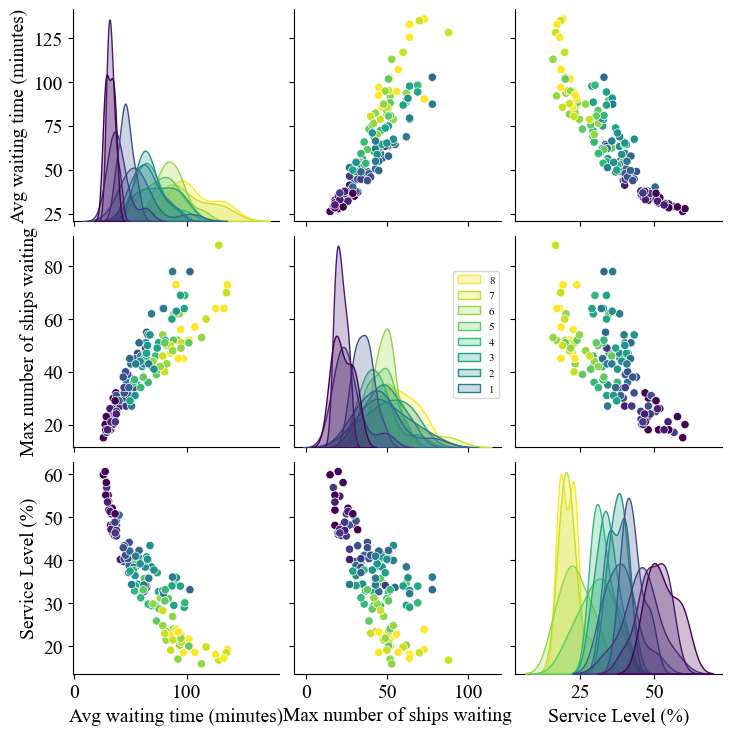

In [8]:
g = sns.pairplot(experiments.loc[:, cols_waiting + [factor_explored]], hue=factor_explored, palette= 'viridis')
g._legend.remove()
# g.fig.legend(handles=handles, labels=labels, loc=(0.6, 0.45), ncol=1, fontsize=10)
plt.legend(range(8,0,-1), loc=(-0.3, 1.3), fontsize=8)
plt.savefig('output/figs/output_analysis/univariate_experiments/' + factor_explored + '/WaitingPairplot.pdf', bbox_inches='tight')
plt.show()

In [9]:
cols_KPIs

['CO2 emissions (kg/day)',
 'Avg lockage time (minutes)',
 'Avg waiting time (minutes)',
 'Number of levelings']

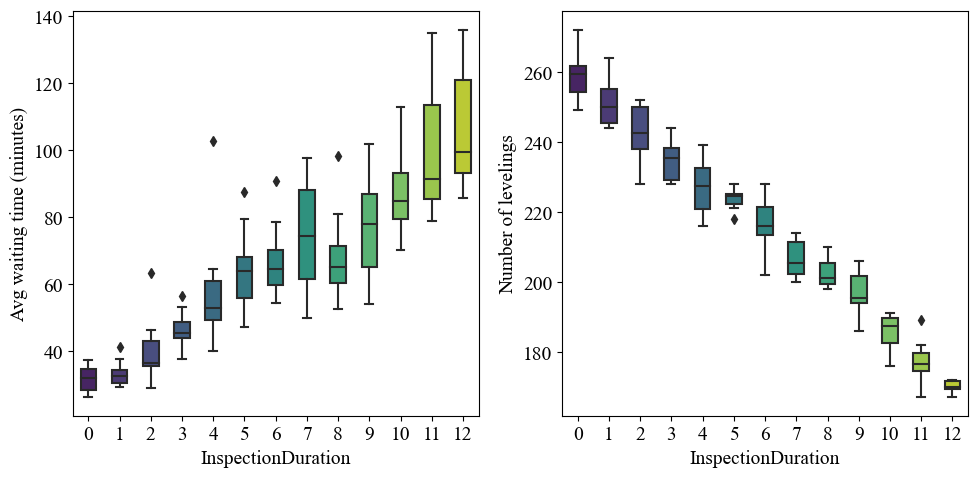

In [12]:
fig, axes = plt.subplots(1,2, figsize=(10, 5), sharey=False)
kpi_set = ['Avg waiting time (minutes)', 'Number of levelings']

for i, kpi in enumerate(kpi_set):
    sns.boxplot(ax= axes[i], y=kpi, x=factor_explored, data=experiments, 
                palette= 'viridis', width=0.5)

plt.tight_layout()
plt.savefig('output/figs/output_analysis/univariate_experiments/' + factor_explored + '/' + str(kpi_set) + '.pdf', bbox_inches='tight')
plt.show()

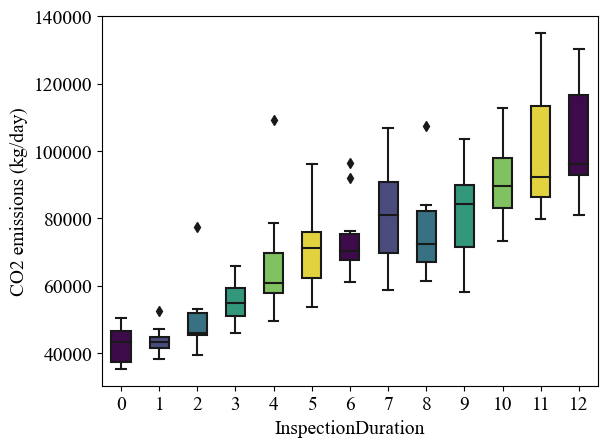

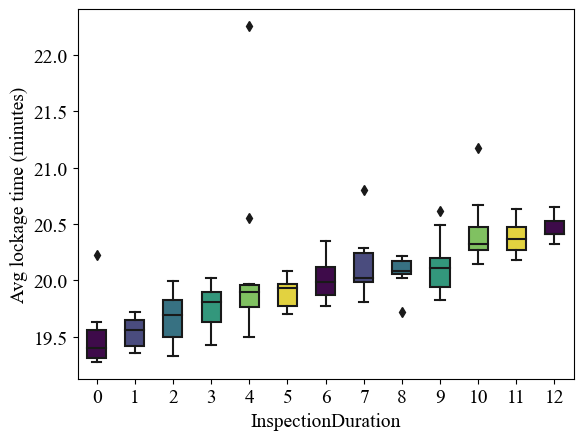

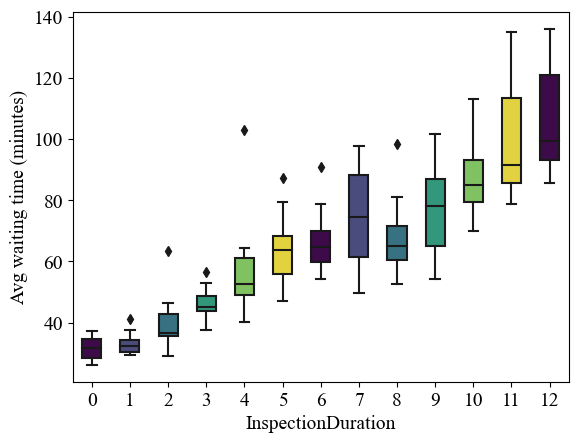

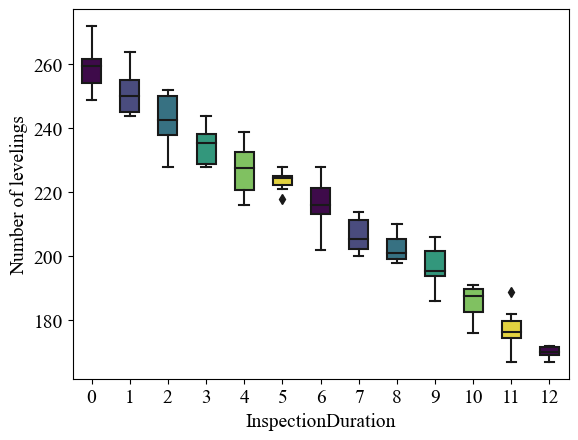

In [13]:
for kpi in cols_KPIs:
    sns.boxplot(y=kpi, x=factor_explored, data=experiments, palette=viridis_colors, width=0.5)
    plt.show()
